In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error,r2_score

In [2]:
df = pd.read_csv('hitters.csv')

In [4]:
df.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
0,293,66,1,30,29,14,1,293,66,1,30,29,14,A,E,446,33,20,NaN,A
1,315,81,7,24,38,39,14,3449,835,69,321,414,375,N,W,632,43,10,475.0,N
2,479,130,18,66,72,76,3,1624,457,63,224,266,263,A,W,880,82,14,480.0,A
3,496,141,20,65,78,37,11,5628,1575,225,828,838,354,N,E,200,11,3,500.0,N
4,321,87,10,39,42,30,2,396,101,12,48,46,33,N,E,805,40,4,91.5,N


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 322 entries, 0 to 321
Data columns (total 20 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   AtBat      322 non-null    int64  
 1   Hits       322 non-null    int64  
 2   HmRun      322 non-null    int64  
 3   Runs       322 non-null    int64  
 4   RBI        322 non-null    int64  
 5   Walks      322 non-null    int64  
 6   Years      322 non-null    int64  
 7   CAtBat     322 non-null    int64  
 8   CHits      322 non-null    int64  
 9   CHmRun     322 non-null    int64  
 10  CRuns      322 non-null    int64  
 11  CRBI       322 non-null    int64  
 12  CWalks     322 non-null    int64  
 13  League     322 non-null    object 
 14  Division   322 non-null    object 
 15  PutOuts    322 non-null    int64  
 16  Assists    322 non-null    int64  
 17  Errors     322 non-null    int64  
 18  Salary     263 non-null    float64
 19  NewLeague  322 non-null    object 
dtypes: float64

In [6]:
def interquantile(dataframe, col_name, q1 = 0.05, q3 = 0.95):
    quantile1 = dataframe[col_name].quantile(q1)
    quantile3 = dataframe[col_name].quantile(q3)
    iqr = quantile3 - quantile1
    
    down = quantile1 - 1.5 * iqr
    up = quantile3 + 1.5 * iqr
    
    return down, up

In [7]:
def check_outliers(dataframe, col_name):
    down, up = interquantile(df, col_name)
    if dataframe[(dataframe[col_name] < down) | (dataframe[col_name] > up)].any(axis=None):
        return True
    else:
        return False

In [8]:
def grab_col_names(df, cat_th=10, car_th=20):
    cat_cols = [col for col in df.columns if df[col].dtypes == "O"]
    num_but_cat = [col for col in df.columns if df[col].nunique() < cat_th and
                   df[col].dtypes != "O"]
    cat_but_car = [col for col in df.columns if df[col].nunique() > car_th and
                   df[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in df.columns if df[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]


    return cat_cols, num_cols, cat_but_car


In [9]:
def replace_with_threshols(dataframe, col_name):
    down, up = interquantile(dataframe,col_name)
    dataframe.loc[(dataframe[col_name] < down), col_name] = down
    dataframe.loc[(dataframe[col_name] > up), col_name] = up
    return dataframe

In [10]:
def high_correlated_cols(dataframe, plot=False, corr_th=0.90):
    corr = dataframe.corr()
    cor_matrix = corr.abs()
    upper_triangle_matrix = cor_matrix.where(np.triu(np.ones(cor_matrix.shape), k=1).astype(np.bool))
    drop_list = [col for col in upper_triangle_matrix.columns if any(upper_triangle_matrix[col] > corr_th)]
    if plot:
        import seaborn as sns
        import matplotlib.pyplot as plt
        sns.set(rc={'figure.figsize': (15, 15)})
        sns.heatmap(corr, cmap="RdBu", annot=True)
        plt.show(block=True)
    return drop_list

In [11]:
cat_cols, num_cols, cat_but_car = grab_col_names(df)


In [12]:
cat_cols

['League', 'Division', 'NewLeague']

In [13]:
num_cols

['AtBat',
 'Hits',
 'HmRun',
 'Runs',
 'RBI',
 'Walks',
 'Years',
 'CAtBat',
 'CHits',
 'CHmRun',
 'CRuns',
 'CRBI',
 'CWalks',
 'PutOuts',
 'Assists',
 'Errors',
 'Salary']

In [14]:
for col in num_cols :
    print(col, check_outliers(df, col))

AtBat False
Hits False
HmRun False
Runs False
RBI False
Walks False
Years False
CAtBat False
CHits False
CHmRun False
CRuns False
CRBI False
CWalks False
PutOuts False
Assists False
Errors False
Salary False


In [15]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
AtBat,322.0,380.928571,153.404981,16.0,255.25,379.5,512.00,687.0
Hits,322.0,101.024845,46.454741,1.0,64.00,96.0,137.00,238.0
HmRun,322.0,10.770186,8.709037,0.0,4.00,8.0,16.00,40.0
Runs,322.0,50.909938,26.024095,0.0,30.25,48.0,69.00,130.0
RBI,322.0,48.027950,26.166895,0.0,28.00,44.0,64.75,121.0
Walks,322.0,38.742236,21.639327,0.0,22.00,35.0,53.00,105.0
Years,322.0,7.444099,4.926087,1.0,4.00,6.0,11.00,24.0
CAtBat,322.0,2648.683230,2324.205870,19.0,816.75,1928.0,3924.25,14053.0
CHits,322.0,717.571429,654.472627,4.0,209.00,508.0,1059.25,4256.0
CHmRun,322.0,69.490683,86.266061,0.0,14.00,37.5,90.00,548.0


C:\Users\s7522\AppData\Local\Temp\ipykernel_14296\1842909412.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = dataframe.corr()
C:\Users\s7522\AppData\Local\Temp\ipykernel_14296\1842909412.py:4: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper_triangle_matrix = cor_matrix.where(np.triu(np.ones(cor_matrix.shape), k=1).astype(np.bool))


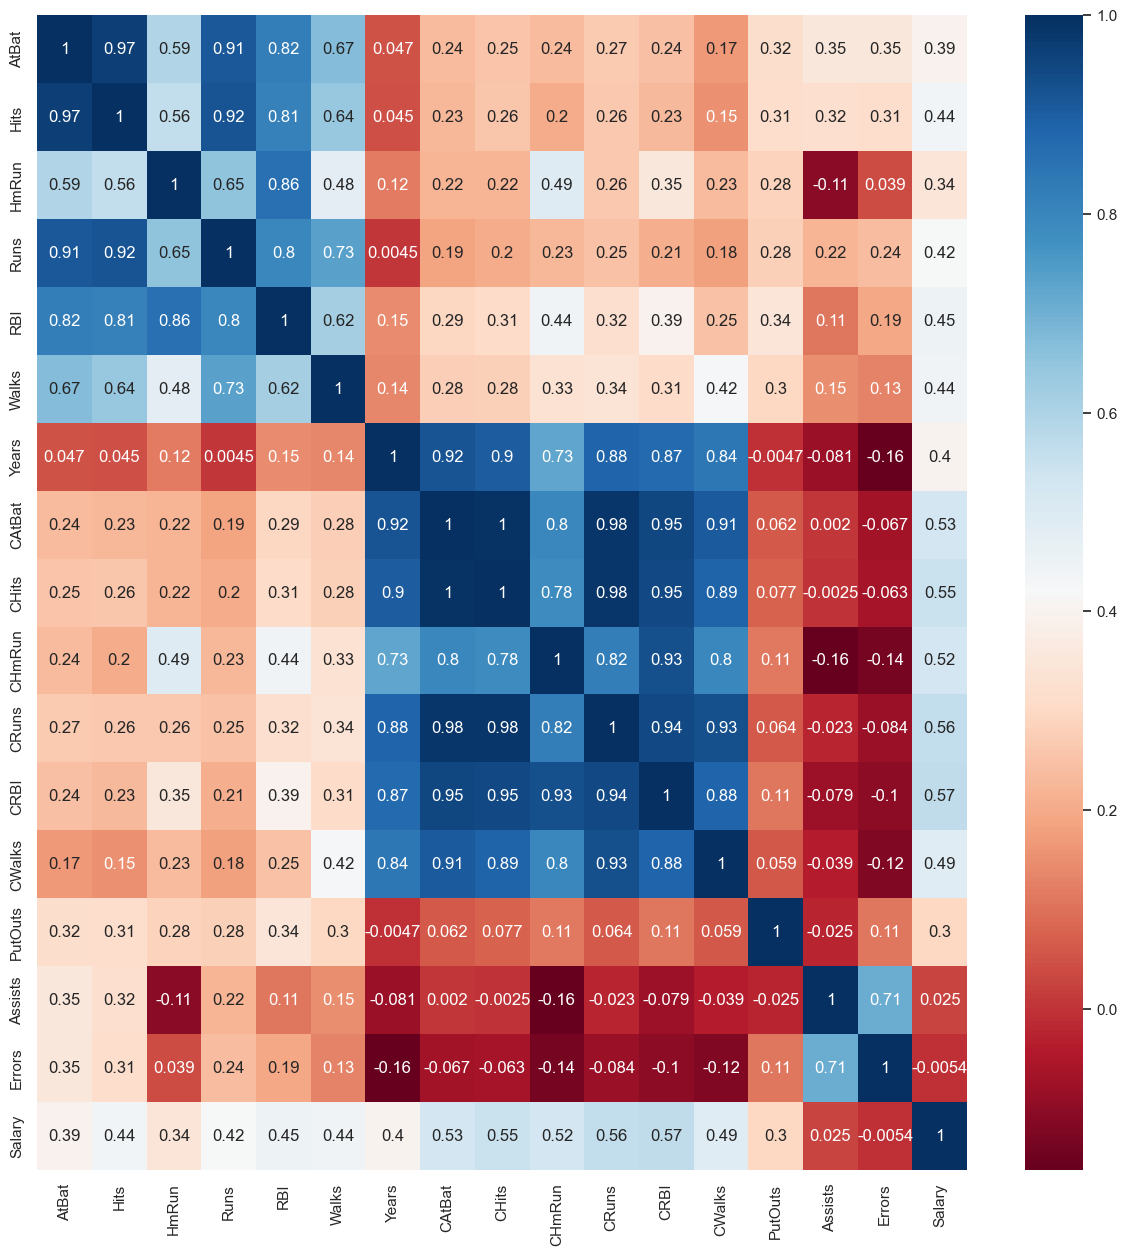

['Hits', 'Runs', 'CAtBat', 'CHits', 'CRuns', 'CRBI', 'CWalks']

In [16]:
high_correlated_cols(df, plot=True)

In [17]:
df.isna().sum()
df.dropna(inplace = True)
df.isna().sum()

AtBat        0
Hits         0
HmRun        0
Runs         0
RBI          0
Walks        0
Years        0
CAtBat       0
CHits        0
CHmRun       0
CRuns        0
CRBI         0
CWalks       0
League       0
Division     0
PutOuts      0
Assists      0
Errors       0
Salary       0
NewLeague    0
dtype: int64

In [18]:
new_num_cols = [col for col in num_cols if col not in ["Salary", "Years"]]
df[new_num_cols] = df[new_num_cols] + 1
df.columns = [col.upper() for col in df.columns]
cat_cols, num_cols, cat_but_car = grab_col_names(df)

In [19]:
# CAREER RUNS RATIO
df["NEW_C_RUNS_RATIO"] = df["RUNS"] / df["CRUNS"]
# CAREER BAT RATIO
df["NEW_C_ATBAT_RATIO"] = df["ATBAT"] / df["CATBAT"]
# CAREER HITS RATIO
df["NEW_C_HITS_RATIO"] = df["HITS"] / df["CHITS"]
# CAREER HMRUN RATIO
df["NEW_C_HMRUN_RATIO"] = df["HMRUN"] / df["CHMRUN"]
# CAREER RBI RATIO
df["NEW_C_RBI_RATIO"] = df["RBI"] / df["CRBI"]
# CAREER WALKS RATIO
df["NEW_C_WALKS_RATIO"] = df["WALKS"] / df["CWALKS"]
df["NEW_C_HIT_RATE"] = df["CHITS"] / df["CATBAT"]
# PLAYER TYPE : RUNNER
df["NEW_C_RUNNER"] = df["CRBI"] / df["CHITS"]
# PLAYER TYPE : HIT AND RUN
df["NEW_C_HIT-AND-RUN"] = df["CRUNS"] / df["CHITS"]
# MOST VALUABLE HIT RATIO IN HITS
df["NEW_C_HMHITS_RATIO"] = df["CHMRUN"] / df["CHITS"]
# MOST VALUABLE HIT RATIO IN ALL SHOTS
df["NEW_C_HMATBAT_RATIO"] = df["CATBAT"] / df["CHMRUN"]

#Annual Averages
df["NEW_CATBAT_MEAN"] = df["CATBAT"] / df["YEARS"]
df["NEW_CHITS_MEAN"] = df["CHITS"] / df["YEARS"]
df["NEW_CHMRUN_MEAN"] = df["CHMRUN"] / df["YEARS"]
df["NEW_CRUNS_MEAN"] = df["CRUNS"] / df["YEARS"]
df["NEW_CRBI_MEAN"] = df["CRBI"] / df["YEARS"]
df["NEW_CWALKS_MEAN"] = df["CWALKS"] / df["YEARS"]


# PLAYER LEVEL
df.loc[(df["YEARS"] <= 2), "NEW_YEARS_LEVEL"] = "Junior"
df.loc[(df["YEARS"] > 2) & (df['YEARS'] <= 5), "NEW_YEARS_LEVEL"] = "Mid"
df.loc[(df["YEARS"] > 5) & (df['YEARS'] <= 10), "NEW_YEARS_LEVEL"] = "Senior"
df.loc[(df["YEARS"] > 10), "NEW_YEARS_LEVEL"] = "Expert"


# PLAYER LEVEL X DIVISION

df.loc[(df["NEW_YEARS_LEVEL"] == "Junior") & (df["DIVISION"] == "E"), 'NEW_DIV_CAT'] = "Junior-East"
df.loc[(df["NEW_YEARS_LEVEL"] == "Junior") & (df["DIVISION"] == "W"), 'NEW_DIV_CAT'] = "Junior-West"
df.loc[(df["NEW_YEARS_LEVEL"] == "Mid") & (df["DIVISION"] == "E"), 'NEW_DIV_CAT'] = "Mid-East"
df.loc[(df["NEW_YEARS_LEVEL"] == "Mid") & (df["DIVISION"] == "W"), 'NEW_DIV_CAT'] = "Mid-West"
df.loc[(df["NEW_YEARS_LEVEL"] == "Senior") & (df["DIVISION"] == "E"), 'NEW_DIV_CAT'] = "Senior-East"
df.loc[(df["NEW_YEARS_LEVEL"] == "Senior") & (df["DIVISION"] == "W"), 'NEW_DIV_CAT'] = "Senior-West"
df.loc[(df["NEW_YEARS_LEVEL"] == "Expert") & (df["DIVISION"] == "E"), 'NEW_DIV_CAT'] = "Expert-East"
df.loc[(df["NEW_YEARS_LEVEL"] == "Expert") & (df["DIVISION"] == "W"), 'NEW_DIV_CAT'] = "Expert-West"

# Player Promotion to Next League
df.loc[(df["LEAGUE"] == "N") & (df["NEWLEAGUE"] == "N"), "NEW_PLAYER_PROGRESS"] = "StandN"
df.loc[(df["LEAGUE"] == "A") & (df["NEWLEAGUE"] == "A"), "NEW_PLAYER_PROGRESS"] = "StandA"
df.loc[(df["LEAGUE"] == "N") & (df["NEWLEAGUE"] == "A"), "NEW_PLAYER_PROGRESS"] = "Descend"
df.loc[(df["LEAGUE"] == "A") & (df["NEWLEAGUE"] == "N"), "NEW_PLAYER_PROGRESS"] = "Ascend"



In [20]:
num_cols
cat_cols
cat_cols, num_cols, cat_but_car = grab_col_names(df)

In [21]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler

In [23]:
def label_encoder(dataframe, binary_col):
    labelencoder = LabelEncoder()
    dataframe[binary_col] = labelencoder.fit_transform(dataframe[binary_col])
    return dataframe


In [24]:
def rare_analyser(dataframe, target, cat_cols):
    for col in cat_cols:
        print(col, ":", len(dataframe[col].value_counts()))
        print(pd.DataFrame({"COUNT": dataframe[col].value_counts(),
                            "RATIO": dataframe[col].value_counts() / len(dataframe),
                            "TARGET_MEAN": dataframe.groupby(col)[target].mean()}), end="\n\n\n")


In [25]:
def rare_encoder(dataframe, rare_perc, cat_cols):
    temp_df = dataframe.copy()
    rare_columns = [col for col in cat_cols if (temp_df[col].value_counts() / len(temp_df) < rare_perc).sum() > 1]

    for col in rare_columns:
        tmp = temp_df[col].value_counts() / len(temp_df)
        rare_labels = tmp[tmp < rare_perc].index
        temp_df[col] = np.where(temp_df[col].isin(rare_labels), 'Rare', temp_df[col])

    return temp_df

In [26]:
def one_hot_encoder(dataframe, categorical_cols, drop_first=False):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first)
    return dataframe

In [27]:
# Label Encoding

binary_cols = [col for col in df.columns if
               df[col].dtype not in [int, float] and df[col].nunique() == 2]

for col in binary_cols:
    df = label_encoder(df, col)


# Rare Encoding

rare_analyser(df,"SALARY", cat_cols)
df = rare_encoder(df, 0.01, cat_cols)


# 6. One-Hot Encoding

ohe_cols = [col for col in df.columns if 10 >= df[col].nunique() > 2]
df = one_hot_encoder(df, ohe_cols, drop_first=True)
cat_cols, num_cols, cat_but_car = grab_col_names(df)
num_cols.remove("SALARY")


# 7. Robust-Scaler
for col in num_cols:
    transformer = RobustScaler().fit(df[[col]])
    df[col] = transformer.transform(df[[col]])

LEAGUE : 2
   COUNT     RATIO  TARGET_MEAN
0    139  0.528517   541.999547
1    124  0.471483   529.117500


DIVISION : 2
   COUNT     RATIO  TARGET_MEAN
0    129  0.490494   624.271364
1    134  0.509506   450.876873


NEWLEAGUE : 2
   COUNT     RATIO  TARGET_MEAN
0    141  0.536122   537.113028
1    122  0.463878   534.553852


NEW_YEARS_LEVEL : 4
        COUNT     RATIO  TARGET_MEAN
Expert     65  0.247148   755.108169
Junior     38  0.144487   186.916658
Mid        78  0.296578   359.339744
Senior     82  0.311787   691.891988


NEW_DIV_CAT : 8
             COUNT     RATIO  TARGET_MEAN
Expert-East     32  0.121673   809.777000
Expert-West     33  0.125475   702.095970
Junior-East     16  0.060837   229.302063
Junior-West     22  0.083650   156.090909
Mid-East        37  0.140684   427.905405
Mid-West        41  0.155894   297.463415
Senior-East     44  0.167300   798.109295
Senior-West     38  0.144487   568.903526


NEW_PLAYER_PROGRESS : 4
         COUNT     RATIO  TARGET_MEAN
Asc

In [28]:
X = df.drop("SALARY", axis=1)
y = df[["SALARY"]]

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.20, random_state=1)

reg_model = LinearRegression()
reg_model.fit(X_train, y_train)

LinearRegression()

In [30]:
reg_model.intercept_


array([717.9331679])

In [31]:
reg_model.coef_


array([[ -249.48220083,   234.64817816,   -63.59079569,   118.42556389,
          112.46938809,    45.98985135,  -310.50890862,  -837.76742964,
          991.92264052,    95.60318652,  -117.47488104,    21.88499177,
           41.89103651,   -31.08792198,   -91.46411511,    33.71692812,
          -35.70817607,    68.75351436,    52.97169756,  -333.12413001,
         1292.77827363, -1071.42040196,    49.14972774,  -277.28517282,
          -44.70659347,  -185.64800261,   -26.75106729,   -25.0472106 ,
          -57.11404603,    16.16051258, -1402.23951906,  1019.0759254 ,
           91.66472441,   211.2084665 ,   167.79988465,     9.01570524,
          -58.87950995,  -175.35776577,   -43.01931993,   -19.77743082,
          -48.40147751,   -10.47803244,  -136.48131527,   -38.8764505 ,
          -20.68711857,   -22.33220136,   -22.13338152,   -30.83831604,
           -8.95454046]])

In [33]:
y_pred = reg_model.predict(X_train)
np.sqrt(mean_squared_error(y_train, y_pred))

206.76747520479267

In [34]:
reg_model.score(X_train, y_train)

0.7819522230250909

In [37]:
from sklearn.model_selection import cross_val_score
cv_scores = cross_val_score(reg_model, X, y, cv=10)
print("Cross-Validation Scores:", cv_scores)
print("Mean Accuracy:", np.mean(cv_scores))
print("Standard Deviation:", np.std(cv_scores))

Cross-Validation Scores: [ 0.14666337  0.74284382  0.64976662  0.70718089  0.68820516  0.75744987
  0.36797459  0.1916232  -0.049792    0.39399465]
Mean Accuracy: 0.45959101625539517
Standard Deviation: 0.2757865028829164


In [38]:
y_pred = reg_model.predict(X_test)
np.sqrt(mean_squared_error(y_test, y_pred))

# Test RKARE
reg_model.score(X_test, y_test)


# 10 Katlı CV RMSE
np.mean(np.sqrt(-cross_val_score(reg_model,
                                 X, y,
                                 cv=10,
                                 scoring="neg_mean_squared_error")))

296.69280034207543